In [1]:
import os
os.environ["LD_LIBRARY_PATH"] = os.environ.get("LD_LIBRARY_PATH", "") + ":/home/juanhevia/.mujoco/mujoco210/bin" + ":/usr/lib/nvidia"

import gymnasium as gym
import json 
import pickle
import numpy as np 
import pandas as pd 
import minari

Import error. Trying to rebuild mujoco_py.
running build_ext
building 'mujoco_py.cymj' extension
gcc -pthread -B /home/juanhevia/miniconda3/envs/aidil/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -fPIC -I/home/juanhevia/miniconda3/envs/aidil/lib/python3.8/site-packages/mujoco_py -I/home/juanhevia/.mujoco/mujoco210/include -I/home/juanhevia/miniconda3/envs/aidil/lib/python3.8/site-packages/numpy/core/include -I/home/juanhevia/miniconda3/envs/aidil/lib/python3.8/site-packages/mujoco_py/vendor/egl -I/home/juanhevia/miniconda3/envs/aidil/include/python3.8 -c /home/juanhevia/miniconda3/envs/aidil/lib/python3.8/site-packages/mujoco_py/cymj.c -o /home/juanhevia/miniconda3/envs/aidil/lib/python3.8/site-packages/mujoco_py/generated/_pyxbld_2.1.2.14_38_linuxgpuextensionbuilder/temp.linux-x86_64-cpython-38/home/juanhevia/miniconda3/envs/aidil/lib/python3.8/site-packages/mujoco_py/cymj.o -fopenmp -w
gcc -pthread -B /home/juanhevia/miniconda3/envs/aidil/compiler_comp

/home/juanhevia/miniconda3/envs/aidil/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# can we use the vector distance between the achieved and desired goal as a termination mark?
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
dataset = minari.load_dataset("kitchen-complete-v1")

From [the documentation](https://robotics.farama.org/envs/franka_kitchen/franka_kitchen/), there are 3 relevant keys:
- `observation`: holds environment observation (like kettle's position or angular velocity of the cabinet door)
- `achieved goal`: this key represents the final goal to be achieved. The value is another Dict space with keys the tasks to be completed in the episode and values the joint goal configuration of each joint in the task as specified in the `Goal` section.
- `desired goal`: this key represents the desired state of the tasks. The value is another Dict space with keys the tasks to be completed in the episode and values the desired joint configuration of each joint in the task.

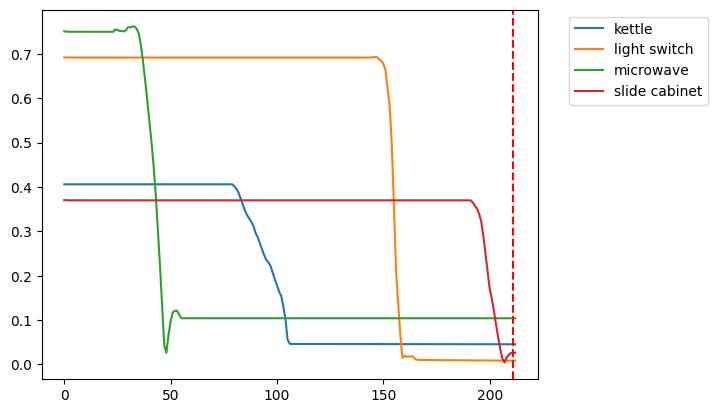

In [4]:
sample_episode = next(dataset.iterate_episodes())

# try for all desired goals
desired_goals = list(sample_episode.observations['desired_goal'].keys())

fig, ax = plt.subplots(1,1,)

for dgoal in desired_goals:
    l2_goal_dist_sample = np.linalg.norm(sample_episode.observations['achieved_goal'][dgoal] - sample_episode.observations['desired_goal'][dgoal], axis=1)
    ax.plot(l2_goal_dist_sample)

ax.legend(desired_goals, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axvline(np.where(sample_episode.truncations)[0][0], color='r', linestyle='--')

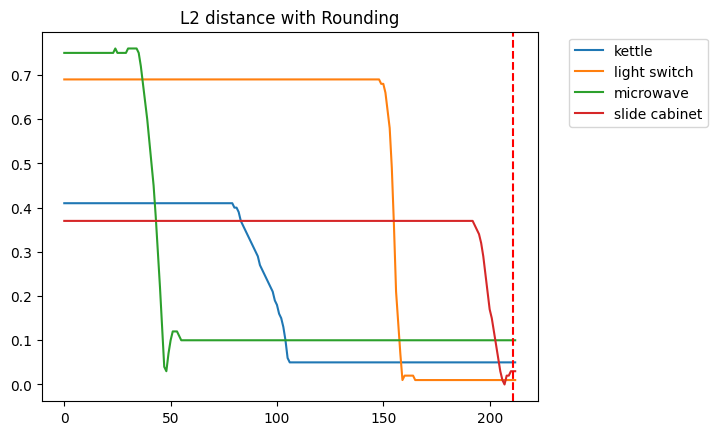

In [5]:

fig, ax = plt.subplots(1,1,)

for dgoal in desired_goals:
    l2_goal_dist_sample = np.linalg.norm(sample_episode.observations['achieved_goal'][dgoal] - sample_episode.observations['desired_goal'][dgoal], axis=1)
    ax.plot(np.round(l2_goal_dist_sample, 2))

ax.legend(desired_goals, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title("L2 distance with Rounding")
ax.axvline(np.where(sample_episode.truncations)[0][0], color='r', linestyle='--')

### Algorithm idea

0. compute the L2 norm between the `achieved_goal` and the `desired_goal` for each timestep.
1. get `np.argmin()` for each separate *l2 norm* trajectory. This gives me the order in which the tasks where executed.
2. use the indices and label (state, action) timesteps so that they map the *currently active* goal.


In [36]:
# load numeric mapping for intents
with open("kitchen_franka_demos/latent_mapping.json", 'r') as f:
    latent_mapping = json.load(f)

latent_mapping

{'microwave': 1,
 'kettle': 2,
 'light switch': 3,
 'slide cabinet': 4,
 'bottom burner': 5,
 'top burner': 6,
 'hinge cabinet': 7}

In [37]:
from typing import Dict, List, OrderedDict

def compute_l2_distances_per_goal(episode) -> OrderedDict[str, List[float]]:
    """
    returns a dict object where keys are the desired goals and values are the l2 distances between the achieved and desired goals.
    """
    desired_goals = list(episode.observations['desired_goal'].keys())

    l2_distances = OrderedDict()

    for dgoal in desired_goals:
        l2_goal_dist_sample = np.linalg.norm(episode.observations['achieved_goal'][dgoal] - episode.observations['desired_goal'][dgoal], axis=1)
        l2_distances[dgoal] = l2_goal_dist_sample
    return l2_distances

l2_distances = compute_l2_distances_per_goal(sample_episode)

def get_completion_order(l2_distances, rounding : int = 2) -> OrderedDict[str, int]:
    """
    returns the index at which the minimum distance was achieved (completion order)
    for each desired goal.
    """
    completion_order = OrderedDict()
    for dgoal, l2_dist in l2_distances.items():
        # completion_order[dgoal] = np.argmin(l2_dist.round(rounding))
        _achiev_idxs = np.argwhere(l2_dist.round(rounding) < 0.3).flatten()
        if len(_achiev_idxs) > 0:
            completion_order[dgoal] = _achiev_idxs[0]
    
    return completion_order

completion_order = get_completion_order(l2_distances)
completion_order

def get_idx_when_increment(array: np.array):
    """
    returns the index when the array increments
    """
    return np.where(array[1:] > array[:-1])[0]

def build_macro_goal_array(rewards: np.array, completion_order: OrderedDict) -> np.array:
    """
    returns a 1D array where the index represents the timestep index and the value
    represents the desired goal that was completed at that timestep.
    """
    traj_len = rewards.shape[0]
    macro_goals = []
    prev_idx = 0
    # sort completion order by index, this ensures accurate macro goal labeling
    _sorted_goal_label = [k for k, v in sorted(completion_order.items(), key=lambda item: item[1])]
    # use reward indices to get an accurate macro goal array
    indices = get_idx_when_increment(rewards)
    
    for goal, idx in zip(_sorted_goal_label, indices):
        macro_goals.extend([latent_mapping[goal]] * (idx - prev_idx))
        prev_idx = idx
    
    # append the last goal to match trajectory length
    if len(macro_goals) < traj_len:
        macro_goals.extend([latent_mapping[goal]] * (traj_len - len(macro_goals)))

    return macro_goals

In [38]:
sample_macro_goals = build_macro_goal_array(sample_episode.rewards, completion_order)
sample_macro_goals[40:90]

[1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3]

In [39]:
get_idx_when_increment(sample_episode.rewards)

array([ 43,  88, 154, 195])

Reward increases 1 unit everytime a new task is completed. So I should use that idx rather than the minimum distance.

In [40]:
def compute_macro_goals(episode) -> np.array:
    l2_distances = compute_l2_distances_per_goal(episode)
    completion_order = get_completion_order(l2_distances)
    macro_goals = build_macro_goal_array(episode.rewards, completion_order)
    return macro_goals

In [41]:
# get macro goals for all episodes
macro_goals = []
for episode in dataset.iterate_episodes():
    macro_goals.append(compute_macro_goals(episode))

In [42]:
# save as pickle file
with open("./kitchen_franka_demos/franka-kitchen-v1-macro-goals.pkl", "wb") as f:
    pickle.dump(macro_goals, f)

# Build trajectory object

In [43]:
sample_episode.observations['observation']

array([[ 1.48752727e-01, -1.76937809e+00,  1.84334368e+00, ...,
         3.35102347e-05,  1.16491251e-05, -2.33916088e-05],
       [ 1.46777065e-01, -1.76395561e+00,  1.85529385e+00, ...,
        -3.85551936e-02, -4.17300486e-02, -1.49818134e-05],
       [ 1.39946439e-01, -1.76393364e+00,  1.86144902e+00, ...,
        -3.07557106e-04, -5.36488968e-02,  2.66140567e-05],
       ...,
       [-2.47392966e+00, -1.25693240e+00,  1.12734051e+00, ...,
         1.17654989e-02,  3.99694738e-03,  2.97183219e-05],
       [-2.47200862e+00, -1.25126117e+00,  1.13779257e+00, ...,
        -4.27727248e-02,  1.18395305e-03,  1.55297810e-04],
       [-2.46619133e+00, -1.24347162e+00,  1.14337411e+00, ...,
         4.57989258e-02, -3.69694849e-04,  1.29566147e-04]])

In [44]:
# load a sample pickle file to get an idea of the data structure
with open(os.path.join('../', 'idil_train', 'experts', 'MultiGoals2D_3-v0_500.pkl'), 'rb') as f:
    example_expert = pickle.load(f)

example_expert.keys()

dict_keys(['states', 'next_states', 'actions', 'latents', 'rewards', 'dones', 'lengths'])

In [45]:
len(example_expert['states'])

500

In [46]:
sample_episode.observations.keys(), sample_episode.rewards

(dict_keys(['achieved_goal', 'desired_goal', 'observation']),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4.

In [47]:
len(example_expert['next_states']), len(example_expert['states'])

(500, 500)

In [48]:
example_expert["lengths"][:5]

[76, 86, 82, 86, 80]

In [49]:
example_expert["next_states"][0][0:4], example_expert["states"][0][0:4]
example_expert["next_states"][0][-3:], example_expert["states"][0][-3:]
len(example_expert['actions']), 

(500,)

In [50]:
def get_episode_data(episode: minari.EpisodeData):
    """
    returns a dictionary with episode data.
    """
    states = episode.observations['observation']
    actions = episode.actions
    rewards = episode.rewards
    dones = episode.truncations
    length = len(dones)
    macro_goals = compute_macro_goals(episode)

    return {
        'states': states[:-1],
        'next_states': states[1:],
        'actions': actions,
        'rewards': rewards,
        'latents': macro_goals,
        'lengths': length,
        'dones': dones
    }

# get episode data for all episodes
_sample_data = get_episode_data(sample_episode)
_sample_data.keys()

for k, v in _sample_data.items():
    if isinstance(v, list) or isinstance(v, np.ndarray):
        print(f"K= {k} --- # records = {len(v)}")

K= states --- # records = 212
K= next_states --- # records = 212
K= actions --- # records = 212
K= rewards --- # records = 212
K= latents --- # records = 212
K= dones --- # records = 212


In [51]:
# parse all episodes
from collections import defaultdict

expert_data = defaultdict(list)

for episode in dataset.iterate_episodes():
    _data = get_episode_data(episode)
    for key, val in _data.items():
        expert_data[key].append(val)

example_expert.keys(), expert_data.keys()

(dict_keys(['states', 'next_states', 'actions', 'latents', 'rewards', 'dones', 'lengths']),
 dict_keys(['states', 'next_states', 'actions', 'rewards', 'latents', 'lengths', 'dones']))

In [52]:
assert set(example_expert.keys()).intersection(set(expert_data.keys())) == set(example_expert.keys()), "Missing keys"

In [53]:
# save to pickle file
with open("./kitchen_franka_demos/FrankaKitchen-v0.pkl", "wb") as f:
    pickle.dump(expert_data, f)

# Test with mixed dataset

After reviewing the definition of the dataset, maybe the wrapped up trajectories can be useful because I can identify finished tasks by the reward and completion index.

In [54]:
mixed_dataset = minari.load_dataset("kitchen-mixed-v1")

In [55]:
len(mixed_dataset.episode_indices) # 621 episodes

621

In [56]:
from tqdm import tqdm
# how many tasks are finished in the dataset?
finished_data = {}
for ep in tqdm(mixed_dataset.iterate_episodes()):
    if any(ep.truncations):
        finished_data[ep.id] = ep.rewards[-1]

621it [00:02, 283.91it/s]


In [57]:
pd.DataFrame.from_dict(finished_data, orient='index', columns=['reward']).value_counts()

reward
2.0       323
3.0       260
1.0        36
0.0         2
Name: count, dtype: int64

In [58]:
# let's keep trajectores with 3 tasks completed
RELEVANT_IDXS = [idx for idx, ep in enumerate(mixed_dataset.iterate_episodes()) if ep.rewards[-1] == 3]
len(RELEVANT_IDXS)

260

In [59]:
# take a sample episode
for ep in mixed_dataset.iterate_episodes():
    if ep.id == RELEVANT_IDXS[10]:
        _episode = ep
        break

In [60]:
_episode

EpisodeData(id=36, seed=123, total_timesteps=259, observations={achieved_goal: {bottom burner: ndarray of shape (260, 2) and dtype float64, kettle: ndarray of shape (260, 7) and dtype float64, light switch: ndarray of shape (260, 2) and dtype float64, microwave: ndarray of shape (260, 1) and dtype float64}, desired_goal: {bottom burner: ndarray of shape (260, 2) and dtype float64, kettle: ndarray of shape (260, 7) and dtype float64, light switch: ndarray of shape (260, 2) and dtype float64, microwave: ndarray of shape (260, 1) and dtype float64}, observation: ndarray of shape (260, 59) and dtype float64}, actions=ndarray of shape (259, 9) and dtype float64, rewards=ndarray of 259 floats, terminations=ndarray of 259 bools, truncations=ndarray of 259 bools, infos=dict with the following keys: [])

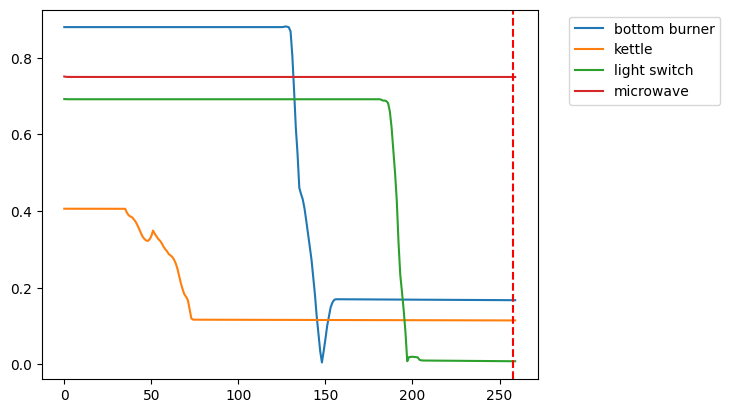

In [61]:
# try for all desired goals
desired_goals = list(_episode.observations['desired_goal'].keys())

fig, ax = plt.subplots(1,1,)

for dgoal in desired_goals:
    l2_goal_dist_sample = np.linalg.norm(_episode.observations['achieved_goal'][dgoal] - _episode.observations['desired_goal'][dgoal], axis=1)
    ax.plot(l2_goal_dist_sample, label=dgoal)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axvline(np.where(_episode.truncations)[0][0], color='r', linestyle='--')

In [62]:
get_idx_when_increment(_episode.rewards)

array([ 57, 140, 191])

In [63]:
get_episode_data(_episode).keys()

dict_keys(['states', 'next_states', 'actions', 'rewards', 'latents', 'lengths', 'dones'])

In [64]:
_episode.truncations

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [65]:
l2_distances_ep = compute_l2_distances_per_goal(_episode)
completion_order_ep = get_completion_order(l2_distances_ep)

In [66]:
np.argwhere(l2_distances_ep['microwave'] < 0.3)

array([], shape=(0, 1), dtype=int64)

In [67]:
get_idx_when_increment(_episode.rewards)

array([ 57, 140, 191])

In [68]:
_mg = compute_macro_goals(_episode)
_mg[48:52] , _mg[128:132]

([2, 2, 2, 2], [5, 5, 5, 5])

In [69]:
len(_mg)

259

In [70]:
def get_episode_data(episode: minari.EpisodeData, mixed_dataset: bool = False, mixed_end_index_padding: int = 20):
    """
    returns a dictionary with episode data.
    """
    states = episode.observations['observation']
    actions = episode.actions
    rewards = episode.rewards
    dones = episode.truncations
    length = len(dones)
    macro_goals = compute_macro_goals(episode)

    if mixed_dataset:
        # get l2 distance to desired goals
        l2_distances = compute_l2_distances_per_goal(episode)
        # get completion order
        completion_order = get_completion_order(l2_distances)
        _max_comp_idx = max(completion_order.values())
        
        # if mixed, let's create an end_idx that equals the last 
        # task completion idx + `end_index_padding` timesteps as a buffer
        END_IDX = _max_comp_idx + mixed_end_index_padding

        # truncate the data
        dones = dones[:END_IDX-1]
        dones = np.append(dones, True)

        # truncate states 
        _states = states[:END_IDX]

        return {
            'states': _states[:-1],
            'next_states': _states[1:],
            'actions': actions[:END_IDX],
            'rewards': rewards[:END_IDX],
            'latents': macro_goals[:END_IDX],
            'lengths': END_IDX,
            'dones': dones[:END_IDX]
        }
    
    return {
        'states': states[:-1],
        'next_states': states[1:],
        'actions': actions,
        'rewards': rewards,
        'latents': macro_goals,
        'lengths': length,
        'dones': dones
    }

In [71]:
# generate expert data for mixed dataset
expert_data_mixed = defaultdict(list)

for episode in mixed_dataset.filter_episodes(lambda ep: ep.id in RELEVANT_IDXS).iterate_episodes():
    _data = get_episode_data(episode, mixed_dataset=True)
    for key, val in _data.items():
        expert_data_mixed[key].append(val)

In [72]:
len(expert_data_mixed['states'])

260

In [73]:
# write to pickle file
with open("./kitchen_franka_demos/FrankaKitchen-v0-mixed_260.pkl", "wb") as f:
    pickle.dump(expert_data_mixed, f)